## Set up

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from mmdet.apis import init_detector, inference_detector
import torch
import cv2
from torchvision.ops import nms

In [11]:
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [15]:
def show_box_detail(box, ax, label, score):
    import matplotlib.font_manager as font_manager
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0, 0, 0, 0), lw=2))

    font_path = '/usr/share/fonts/truetype/arphic/uming.ttc'  # 替换为你的中文字体文件路径
    font_prop = font_manager.FontProperties(fname=font_path)

    ax.text(x0, y0 - 10, f"{label}: {score:.2f}", color='red', fontsize=26, fontproperties=font_prop)

In [4]:
# def show_mask(mask, ax, random_color=False, borders = True):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask = mask.astype(np.uint8)
#     mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     if borders:
#         import cv2
#         contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
#         # Try to smooth contours
#         contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
#         mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
#     ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [16]:
# def show_mask(mask, ax, random_color=True, borders = True):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask = mask.astype(np.uint8)
#     mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     if borders:
#         import cv2
#         contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
#         # Try to smooth contours
#         contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
#         mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
#     ax.imshow(mask_image)

In [6]:
def show_mask(mask, ax, random_color=True, borders=True):
    mask = np.squeeze(mask)  # Remove any singleton dimensions, e.g., (1, 360, 480) -> (360, 480)

    print("After squeeze - Mask shape:", mask.shape)
    print("Mask dtype:", mask.dtype)
    
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])

    h, w = mask.shape[-2:]  # mask should now be (360, 480)
    mask = mask.astype(np.uint8)

    if mask.ndim == 2:
        pass  # Already single-channel
    else:
        raise ValueError(f"Unexpected mask dimensions or channels: {mask.shape}")
    
    # Convert to 8-bit if necessary
    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)

    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    if borders:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    
    ax.imshow(mask_image)  # Ensure ax is an Axes object


In [18]:
categories = [
    {"id": 1, "name": "电流互感器"}, # TA
    {"id": 2, "name": "母线"}, # W
    {"id": 3, "name": "散热器"}, # SQR
    {"id": 4, "name": "电抗器"}, # L
    {"id": 5, "name": "避雷器"}, # FV
    {"id": 6, "name": "套管"}, # CM
    {"id": 7, "name": "电压互感器"}, # TV
    {"id": 8, "name": "断路器"}, # QF
    {"id": 9, "name": "电容器"}, # C
    {"id": 10, "name": "变压器"}, # T
    {"id": 11, "name": "绝缘子"}, # JYZ
    {"id": 12, "name": "隔离开关"}, # QS
]

# 从1开始，但标签从0开始，给label+1
names = ['None', "电流互感器", "母线", "散热器", "电抗器", "避雷器", "套管", "电压互感器", "断路器", "电容器", "变压器", "绝缘子", "隔离开关"]
english_names = ['None', "TA", "W", "SQR", "L", "FV", "CM", "TV", "QF", "C", "T", "JYZ", "QS"]
colors = [[1, 1, 1, 0.6],
          [30/255, 144/255, 255/255, 0.6],
          [21/255, 168/255, 72/255, 0.6],
          [21/255, 43/255, 168/255, 0.6],
          [72/255, 21/255, 168/255, 0.6],
          [146/255, 21/255, 168/255, 0.6],
          [168/255, 21/255, 43/255, 0.6],
          [168/255, 72/255, 21/255, 0.6],
          [168/255, 146/255, 21/255, 0.6],
          [116/255, 168/255, 21/255, 0.6],
          [57/255, 222/255, 27/255, 0.6],
          [101/255, 233/255, 78/255, 0.6],
          [210/255, 78/255, 233/255, 0.6]]

In [24]:
def yolox_sam2(file_path,det_model, filter_threshold, verbose):
    """
    file_path: The path of the image being processed under the predefined directory

    det_model: Pre-defined detection model initiated with check_point and config_file.
    
    filter_threshold: 
        1) If input is a number, then the input will function as threshold to keep only the most confident detections.
        2) If input is not a number, then the output will return the bounding box with the highest score.

    verbose:
        1) If input is 1, the execution details will be displaced.
        2) If input is not 1, no execution details will be displaced.

    """
    
    results = inference_detector(det_model, file_path)

    print(f"\nProcessing file: {file_path}")

    image = Image.open(file_path)
    image = np.array(image.convert("RGB"))
    predictor.set_image(image)
    
    # Assuming results is a DataSample object
    pred_instances = results.pred_instances  # Access the predicted instances

    # Extracting bounding boxes, scores, and labels
    bboxes = pred_instances.bboxes.cpu().numpy()  # Convert to numpy array for easier handling
    scores = pred_instances.scores.cpu().numpy()  # Convert to numpy array for easier handling
    labels = pred_instances.labels.cpu().numpy()

    if verbose == 1:
        print("\n Start Processing file", filename)
        
        print("Bounding boxes:\n", bboxes)
        print("\n")

        print("Scores:\n", scores)
        print("\n")

        print("Labels:\n", labels)
        print("\n")

    # # Find the index of the highest score
    # max_score_index = scores.argmax()


    # if isinstance(filter_threshold, (int, float)):
    #     score_threshold = filter_threshold
    #     valid_indices = scores > score_threshold
    #     filtered_bboxes = bboxes[valid_indices]
    #     filtered_scores = scores[valid_indices]
    # else:
    #     # Filter to retain only the bounding box with the highest score
    #     filtered_bboxes = bboxes[max_score_index:max_score_index+1]  # Slice to keep it as a 2D array
    #     filtered_scores = scores[max_score_index:max_score_index+1]  # Slice to keep it as a 1D array
    
    # refined_bboxes = filtered_bboxes
    # refined_scores = filtered_scores
    
    # if not isinstance(refined_bboxes, np.ndarray):
    #     refined_bboxes = np.array([refined_bboxes])
    # if not isinstance(refined_scores, np.ndarray):
    #     refined_scores = np.array([refined_scores])
    
    # if verbose == 1:
    #     print("Filtered bounding boxes:", filtered_bboxes)
    #     print("Filtered scores:", filtered_scores)
    #     print("\n")
    
    # for bbox, label, score in zip(refined_bboxes, labels, refined_scores) :
    #     masks, _, _ = predictor.predict(
    #         point_coords=None,
    #         point_labels=None,
    #         box=bbox,
    #         multimask_output=False
    #     )
    
    #     # Refine masks
    #     refined_masks = [refine_mask(mask) for mask in masks]

    for bbox, label, score in zip(bboxes, labels, scores) :

        # print(f"Here is the bbox: \n {bbox}")
        # print(f"Here is the label: \n {label}")
        # print(f"Here is the score: \n {score}")


        
        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=bbox,
            multimask_output=False
        )

    
        # Visualize or process the masks as needed
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        show_mask(masks, plt.gca(), True)
        show_box_detail(bbox, plt.gca(), names[label], score)
        plt.axis('off')
        plt.show()

    
    
    

## Batch Prompt Workflow on Multiple Image

In [1]:
# import os
# import time

# # Define the directory path where your .jpg files are located
# folder_path = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train'

# # Initialize a counter
# file_count = 0

# # Start the timer
# start_time = time.time()

# config_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/self_x.py'
# checkpoint_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'


# # Loop through all the files in the directory
# for filename in os.listdir(folder_path):
#     # Check if the file is a .jpg file
#     det_model = init_detector(config_file, checkpoint_file, device=device)
    
#     if filename.endswith('.jpg'):
#         # Construct the full path to the file
#         file_path = os.path.join(folder_path, filename)

#         results = inference_detector(det_model, file_path)
        
#         # Your code to process the image goes here
#         yolox_sam2(file_path, det_model, "h", 0)
        
        
#         # Increment the counter
#         file_count += 1
        
#         # Break the loop if the counter reaches 100
#         if file_count >= 3:
#             print(f"Reached the limit of {file_count} files.\n")
#             break


# # End the timer
# end_time = time.time()

# # Calculate the total processing time
# total_time = (end_time - start_time) / file_count

# # Print the total processing time
# print(f"Processing time per image is: {total_time:.5f} seconds")


## Results in one picture

In [21]:
def yolox_sam2(file_path, det_model, filter_threshold, verbose):
    """
    Processes the image file using YOLOX and SAM2, and visualizes the results.

    file_path: The path of the image being processed.
    det_model: Pre-defined detection model initiated with checkpoint and config_file.
    filter_threshold: 
        1) If input is a number, it will function as a threshold to keep only the most confident detections.
        2) If input is not a number, it will return the bounding box with the highest score.
    verbose:
        1) If input is 1, the execution details will be displayed.
        2) If input is not 1, no execution details will be displayed.
    """
    
    results = inference_detector(det_model, file_path)

    print(f"\nProcessing file: {file_path}")

    # Load and prepare the image
    image = Image.open(file_path)
    image = np.array(image.convert("RGB"))
    predictor.set_image(image)
    
    # Access predicted instances
    pred_instances = results.pred_instances

    # Extract bounding boxes, scores, and labels
    bboxes = pred_instances.bboxes.cpu().numpy()  # Convert to numpy array for easier handling
    scores = pred_instances.scores.cpu().numpy()  # Convert to numpy array for easier handling
    labels = pred_instances.labels.cpu().numpy()

    if verbose == 1:
        print("\n Start Processing file", file_path)
        print("Bounding boxes:\n", bboxes)
        print("Scores:\n", scores)
        print("Labels:\n", labels)

    # Initialize plot
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    # Process each detection
    for bbox, label, score in zip(bboxes, labels, scores):
        if score > 0.5:
            masks, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=bbox,
                multimask_output=False
            )
    
            # Overlay the mask on the image
            show_mask(masks, plt.gca(), True)
            show_box_detail(bbox, plt.gca(), names[label], score)

    # Finalize and display the plot
    plt.axis('off')
    plt.show()


Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_3212.jpg
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mas

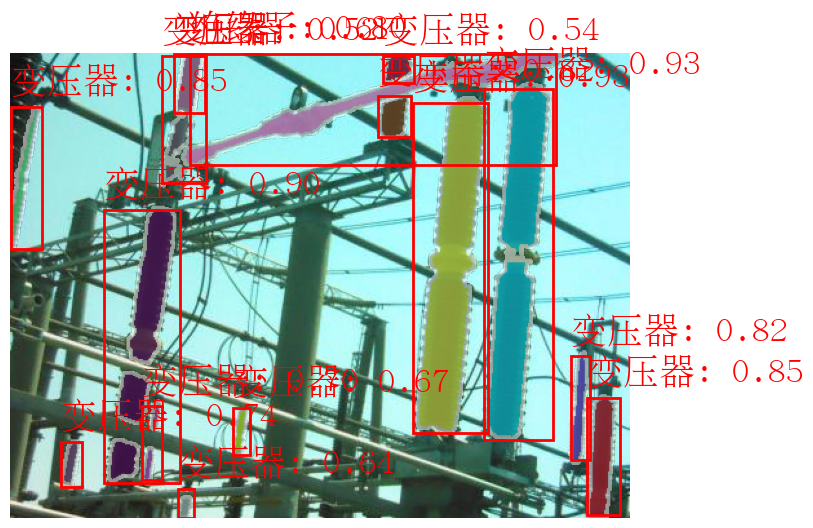

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_2966.jpg
After squeeze - Mask shape: (480, 640)
Mask dtype: float32
After squeeze - Mask shape: (480, 640)
Mask 

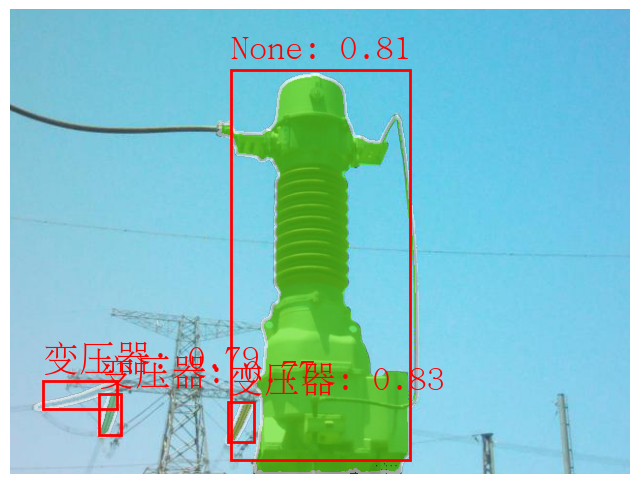

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_557.jpg
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32


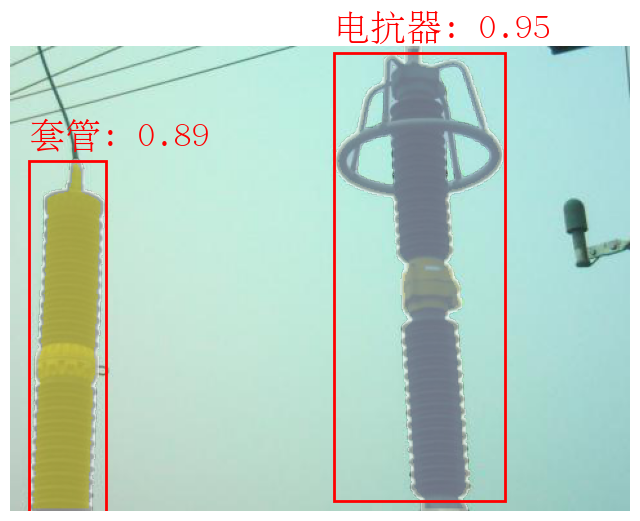

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_1254.jpg
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32


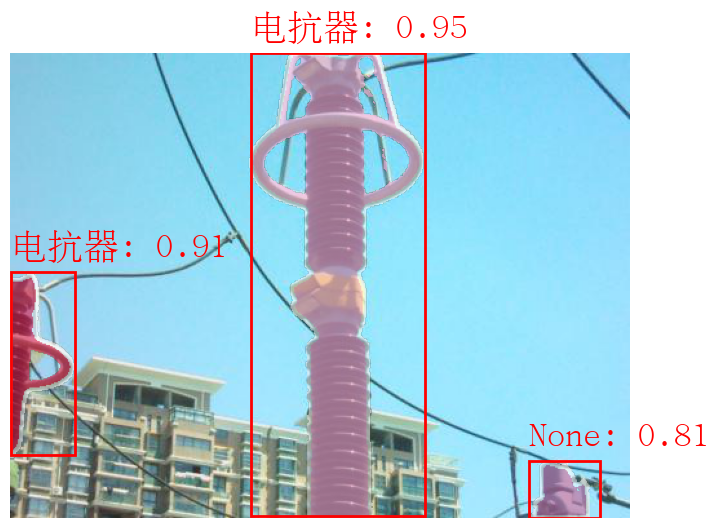

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_6898.jpg
After squeeze - Mask shape: (1536, 2048)
Mask dtype: float32
After squeeze - Mask shape: (1536, 2048)
Mask dtype: float32
After squeeze - Mask shape: (1536, 2048)
Mask dtype: float32
After squeeze - Mask shape: (1536, 2048)
Mask dtype: float32
After squeeze - Mask shape: (1536, 2048)
Mask dtype: float32
After squeeze - Mask shape: (1536, 2048)
Mask dtype: float32
After squeeze - Mask shape: (1536, 2048)
Mask dtype: float32
After squeeze - Mask shape: (1536, 2048)
Mask dtype: float32
After squeeze - Mask shape: (1536, 2048)
Mask dtype: float32
After squeeze - Mask s

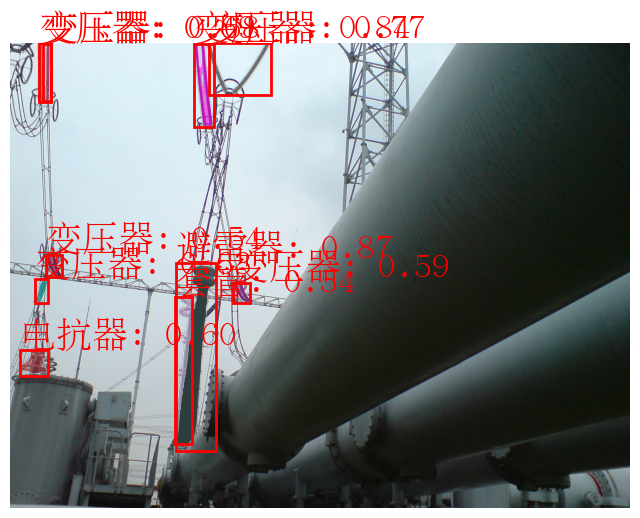

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_1460.jpg
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
Af

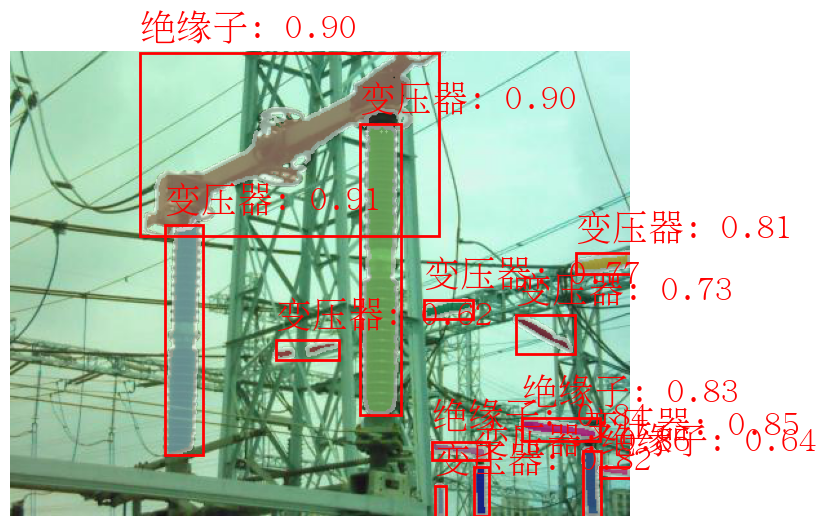

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_5405.jpg
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask sh

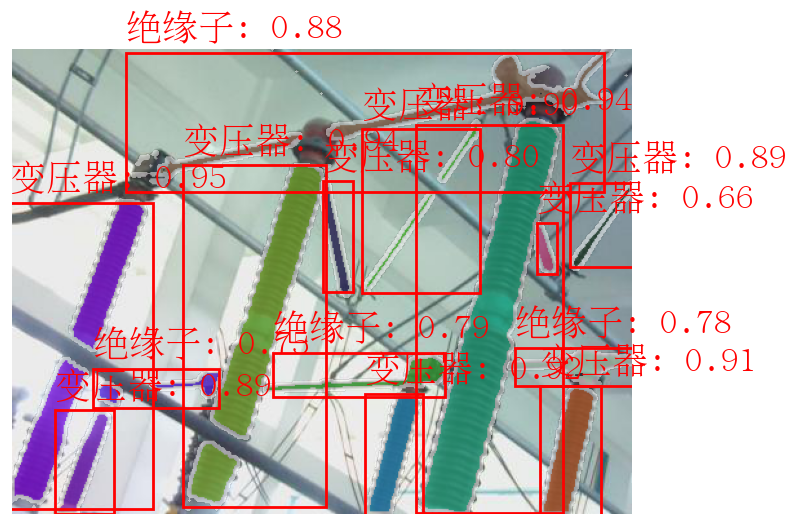

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_1783.jpg
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask 

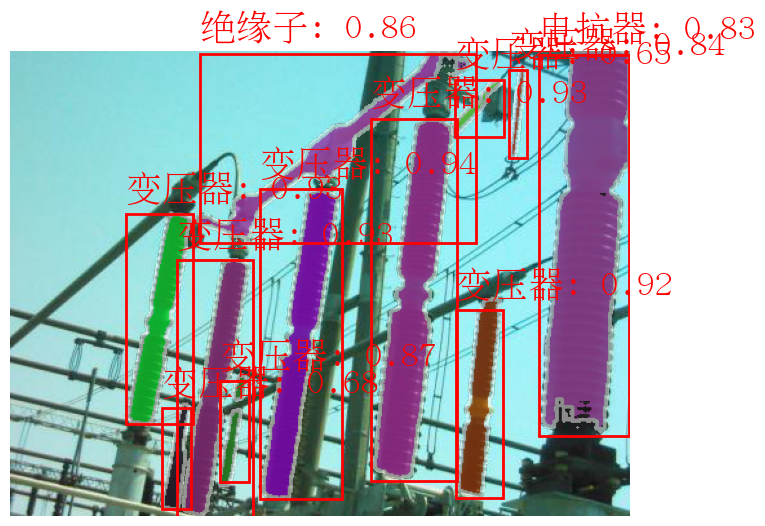

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth
Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_2399.jpg
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
After squeeze - Mask shape: (360, 480)
Mask dtype: float32
Af

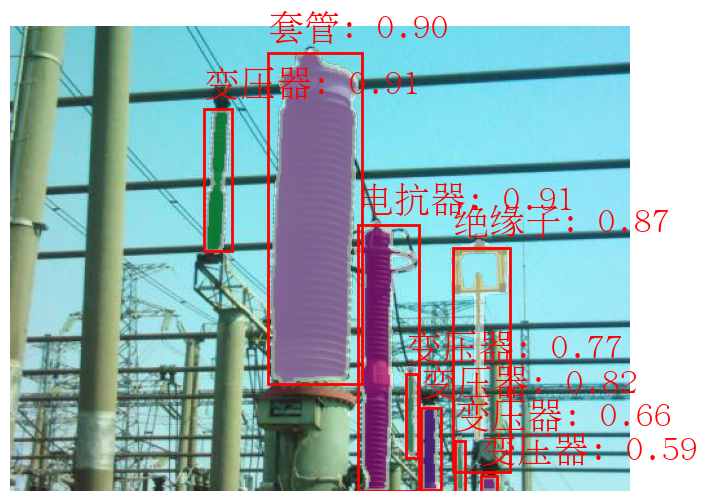

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth

Processing file: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train/sa_3691.jpg
After squeeze - Mask shape: (480, 640)
Mask dtype: float32
After squeeze - Mask shape: (480, 640)
Mask dtype: float32
After squeeze - Mask shape: (480, 640)
Mask dtype: float32
After squeeze - Mask shape: (480, 640)
Mask dtype: float32
After squeeze - Mask shape: (480, 640)
Mask dtype: float32
After squeeze - Mask shape: (480, 640)
Mask dtype: float32
After squeeze - Mask shape: (480, 640)
Mask dtype: float32
After squeeze - Mask shape: (480, 640)
Mask dtype: float32


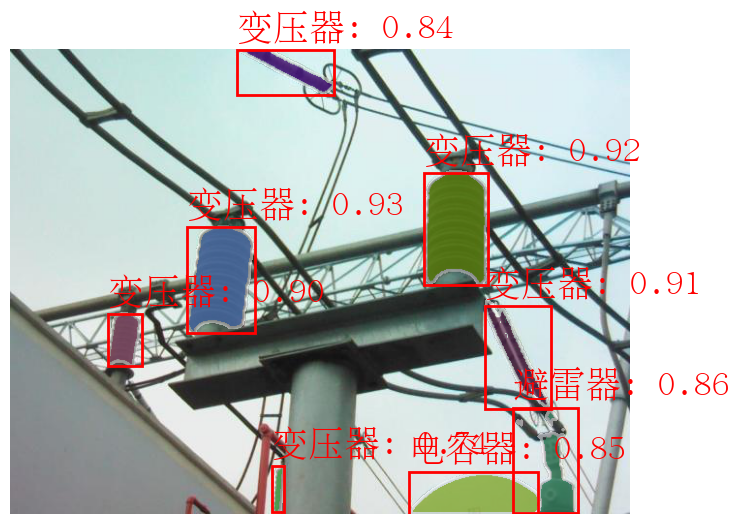

Reached the limit of 10 files.

Processing time per image is: 5.50624 seconds


In [22]:
import os
import time

# Define the directory path where your .jpg files are located
folder_path = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/SlimSAM-master/data/train'

# Initialize a counter
file_count = 0

# Start the timer
start_time = time.time()

config_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/self_x.py'
checkpoint_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Loop through all the files in the directory
for filename in os.listdir(folder_path):
    # Check if the file is a .jpg file
    det_model = init_detector(config_file, checkpoint_file, device=device)
    
    if filename.endswith('.jpg'):
        # Construct the full path to the file
        file_path = os.path.join(folder_path, filename)

        results = inference_detector(det_model, file_path)
        
        # Your code to process the image goes here
        yolox_sam2(file_path, det_model, "h", 0)
        
        
        # Increment the counter
        file_count += 1
        
        # Break the loop if the counter reaches 100
        if file_count >= 10:
            print(f"Reached the limit of {file_count} files.\n")
            break


# End the timer
end_time = time.time()

# Calculate the total processing time
total_time = (end_time - start_time) / file_count

# Print the total processing time
print(f"Processing time per image is: {total_time:.5f} seconds")
